# Prompt Engineering Basic Techniques

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio on ml.t3.medium instance*

---

In this demo notebook, we demonstrate how to use the boto3 Python SDK to work with Amazon Bedrock Foundation Models. If you are running this in AWS provided accounts, excessive API calls to Bedrock APIs may results in throttling and your account may get blocked

In this demo notebook, we are going to explore some of the PROMPT Engineering Techniques for better model output generation.


---

In [2]:
import sys
import os
module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils.environment_validation import validate_environment, validate_model_access
validate_environment()

Validating base environment
awscli>=1.29.57 has been installed successfully.
pydantic>2 has been installed successfully.
Base environment validated successfully


Validating lab environment from requirements.txt ✨

ENVIRONMENT STATUS
✅  langchain-aws is installed
✅  sqlalchemy is installed
✅  datasets is installed
✅  matplotlib is installed
❌ langchain==0.1.14 is not installed
❌ pypdf>=3.8,<4 is not installed
❌ pymupdf  is not installed
❌ xmltodict==0.13.0 is not installed
❌ duckduckgo-search is not installed
❌ yfinance is not installed
❌ pandas-datareader is not installed
❌ pysqlite3 is not installed

Installing missing libraries

langchain==0.1.14 has been installed successfully.
pypdf>=3.8,<4 has been installed successfully.
pymupdf  has been installed successfully.
xmltodict==0.13.0 has been installed successfully.
duckduckgo-search has been installed successfully.
yfinance has been installed successfully.
pandas-datareader has been installed successfully.
pysqlite3 has been installed successfully.


All required libraries are installed.🎉
You may proceed with the lab! 🚀

In [3]:
required_models = [
    "amazon.titan-embed-text-v1",
    "anthropic.claude-3-sonnet-20240229-v1:0",
    "anthropic.claude-3-haiku-20240307-v1:0",
    "meta.llama3-70b-instruct-v1:0",
    "meta.llama3-8b-instruct-v1:0",
    "mistral.mixtral-8x7b-instruct-v0:1"
]

validate_model_access(required_models)

MODEL ACCESS STATUS
✅  amazon.titan-embed-text-v1 is accessible
✅  anthropic.claude-3-sonnet-20240229-v1:0 is accessible
✅  anthropic.claude-3-haiku-20240307-v1:0 is accessible
✅  meta.llama3-70b-instruct-v1:0 is accessible
✅  meta.llama3-8b-instruct-v1:0 is accessible
✅  mistral.mixtral-8x7b-instruct-v0:1 is accessible

All required models are accessible.🎉
You may proceed with the lab! 🚀

In [4]:

#Create the bedrock client for model access
import json

from rich import print as rprint
from rich.markdown import Markdown

import boto3
import botocore

from utils import bedrock, print_ww
from utils.prompt_utils import prompts_to_messages, convert_pdf_to_image, convert_pil_image_to_b64

boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
    runtime=False
)

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock(https://bedrock.us-east-1.amazonaws.com)


#### Validate the connection

We can check the client works by trying out the `list_foundation_models()` method, which will tell us all the models available for us to use 

In [ ]:

boto3_bedrock.list_foundation_models()


---

## `InvokeModel` body and output

The `invoke_model()` method of the Amazon Bedrock runtime client (`InvokeModel` API) will be the primary method we use for most of our Text Generation and Processing tasks - whichever model we're using.

Although the method is shared, the format of input and output varies depending on the foundation model used - as described below:

### Anthropic Claude Completion API format

#### Input

**<|begin_of_text|>**: This is equivalent to the BOS token

<|eot_id|>: This signifies the end of the message in a turn.

<|start_header_id|>{role}<|end_header_id|>: These tokens enclose the role for a particular message. The possible roles can be: system, user, assistant.

<|end_of_text|>: This is equivalent to the EOS token. On generating this token, Llama 3 will cease to generate more tokens.
A prompt can optionally contain a single system message, or multiple alternating user and assistant messages, but always ends with the last user message followed by the assistant header.

---

## Try out the LLaMa3 Model

With some theory out of the way, let's see the models in action! Run the cells below to see basic, synchronous example invocations for each model:


In [6]:
from langchain_core.prompts import PromptTemplate


def prompt_format(system_prompt="", user_data = "", context_data = ""):

    template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>{system}<|eot_id|><|start_header_id|>user<|end_header_id|> context: {context} \n question:{user}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    prompt = PromptTemplate.from_template(template)
    return prompt.format(system=system_prompt, user=user_data, context=context_data)


def invoke_model_and_get_response(prompt_data):

    body = json.dumps({
        'prompt': prompt_data,
        'max_gen_len': 1024,
        'top_p': 0.9,
        'temperature': 0.2
    })

    try:
        response = bedrock_runtime.invoke_model(body=body, modelId=modelId)
        response_body = json.loads(response.get('body').read().decode('utf-8'))
        outputText = response_body['generation'].strip()
        return outputText

    except botocore.exceptions.ClientError as error:
        if error.response['Error']['Code'] == 'AccessDeniedException':
            return (f"\x1b[41m{error.response['Error']['Message']}\
                    \nTo troubleshoot this issue please refer to the following resources.\
                     \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                     \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")
        else:
            raise


bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None))

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


In [9]:


modelId = "meta.llama3-8b-instruct-v1:0"

system_prompt = """You are a helpful, respectful and honest assistant.
Always answer as helpfully as possible, while being safe.
Your answers should not include any harmful, unethical, racist, sexist, toxic,
dangerous, or illegal content. Please ensure that your responses are socially
unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why
instead of answering something not correct. If you don't know the answer to a
question, please don't share false information.
"""
context_data = ""

user_data = "Hi Llama, how are you?"


prompt_data = prompt_format (system_prompt, user_data, context_data)



#### Claude Prompts
As the message based API has become the standard way to prompt Claude models, we will utilize a small helper function `prompts_to_messages` that will convert our prompt into the message format expected by the API.

In [10]:

invoke_model_and_get_response(prompt_data)


'Hello there! As a helpful assistant, I don\'t have feelings or emotions like humans do, so I don\'t have a personal state of being like "good" or "bad". I exist solely to provide information and assist with tasks to the best of my abilities! I\'m always ready to help with any questions or topics you\'d like to discuss. How can I assist you today?'

## Prompt Engineering - Basic Techiques

In this section, we are going to explore some basic prompting engineering techniques.

---

### Zero-shot prompting
Zero Shot prompting describes the technique where we present a task to an LLM without giving it further examples. We therefore, expect it to perform the task without getting a prior “shot” at the task. Hence, “zero-shot” prompting. Modern LLMs demonstrate remarkable zero-shot performance and a positive correlation can be drawn between model size and zero-shot performance.

In [13]:
# If you'd like to try your own prompt, edit this parameter!

system_prompt = """You are a customer service agent tasked with classifying emails by type. Please output your answer and then justify your classification. How would you categorize this email? """

user_data = """
<email>
I would like to know how I can contribute to my retirement account? Any additional resources to read about IRA would be helpful
</email>
Provide and explanation for your choice of answer

The categories are:
(A) IRA
(B) 529 Plan
(C) Cash Management
(D) Youth Account
"""

prompt_data = prompt_format(system_prompt, user_data, context_data)
print(invoke_model_and_get_response(prompt_data))

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>You are a customer service agent tasked with classifying emails by type. Please output your answer and then justify your classification. How would you categorize this email? <|eot_id|><|start_header_id|>user<|end_header_id|> context:  \n question:\n<email>\nI would like to know how I can contribute to my retirement account? Any additional resources to read about IRA would be helpful\n</email> \nProvide and explanation for your choice of answer\n\nThe categories are: \n(A) IRA \n(B) 529 Plan\n(C) Cash Management\n(D) Youth Account\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>'

---

### Few-shot prompting
Giving the model more information about the tasks at hand via examples is called Few-Shot Prompting. It can be used for in-context learning by providing examples of the task and the desired output. We can therefore condition the model on the examples to follow the task guidance more closely.

In [15]:
# If you'd like to try your own prompt, edit this parameter!

system_prompt = """Your job is to generate financial summaries similar to the examples below:
Microsoft: Microsoft reported record revenue of $51.9 billion in its latest
quarterly earnings report, a 20% increase year-over-year. Its net income rose
to $16.7 billion, up 21% compared to the previous year. Microsoft's revenue
growth was driven by its cloud computing business Azure and Office 365
productivity tools.

Amazon: In its most recent quarterly results, Amazon reported net sales of
$96.1 billion, an increase of 15% compared to the same period last year.
Amazon's net income decreased to $2.9 billion, down 58% year-over-year,
as the company faced rising costs due to inflation and supply chain issues.
Amazon Web Services, its cloud computing segment, continued to see strong growth
with sales up 33%.
"""

user_data = """
Now provide a brief financial summary for Apple Inc. based on the following key facts:
- Revenue for the last 12 months: $260 billion 
- Net income: $55 billion
- Total assets: $321 billion
- Market capitalization: $2.2 trillion

"""

context_data = ""
prompt_data = prompt_format(system_prompt, user_data, context_data)
print(invoke_model_and_get_response(prompt_data))

"Apple Inc. reported a remarkable 12-month period, with revenue reaching $260 billion, a significant milestone for the technology giant. The company's net income also saw a substantial increase, reaching $55 billion, a 21% year-over-year growth. Apple's total assets stood at $321 billion, a testament to its strong financial position. Notably, the company's market capitalization reached an impressive $2.2 trillion, a reflection of its dominance in the tech industry."

---

### Chain of Thought prompting
Chain-of-thought (CoT) prompting enables complex reasoning capabilities **through intermediate reasoning** steps. You can combine it with few-shot prompting to get better results on more complex tasks that require reasoning before responding. The main idea of CoT is that by showing the LLM some few shot exemplars where the reasoning process is explained in the exemplars, the LLM will also show the reasoning process when answering the prompt. This explanation of reasoning often leads to more accurate results.


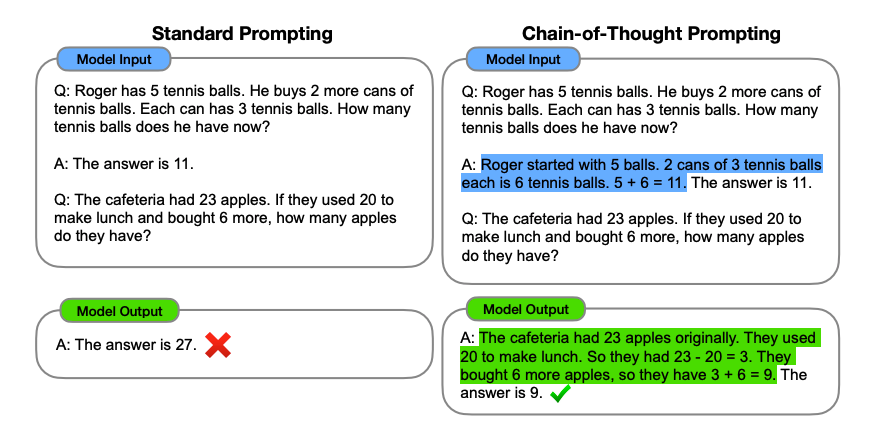

In [10]:
# If you'd like to try your own prompt, edit this parameter!
modelId = "meta.llama3-8b-instruct-v1:0"

user_data = """
Apple Inc. key facts:
- Revenue for the last 12 months: $260 billion 
- Operating Expenses: $205 billion
- Total assets: $321 billion
- Market capitalization: $2.2 trillion

If Apple's revenue is expected to grow by 10% in the next year,
however it's expenses are expected to increase by 15%, what would be the
expected net income for Apple in the next year?

Think step-by-step and provide your thought process in the <thinking></thinking>
XML tags and the final answer in the <answer></answer> XML tags.

"""
system_prompt=""
context_data=""
prompt_data = prompt_format(system_prompt, user_data, context_data)
print(invoke_model_and_get_response(prompt_data))

"<thinking>\n\nFirst, let's calculate the expected revenue for the next year:\n\nRevenue for the last 12 months: $260 billion\nExpected revenue growth: 10%\nExpected revenue for the next year: $260 billion x (1 + 0.10) = $286 billion\n\nNext, let's calculate the expected operating expenses for the next year:\n\nOperating Expenses for the last 12 months: $205 billion\nExpected expense growth: 15%\nExpected operating expenses for the next year: $205 billion x (1 + 0.15) = $236 billion\n\nNow, let's calculate the expected net income for the next year:\n\nExpected revenue for the next year: $286 billion\nExpected operating expenses for the next year: $236 billion\nExpected net income for the next year: $286 billion - $236 billion = $50 billion\n\n</thinking>\n\n<answer>$50 billion</answer>"

In [16]:
user_data = """The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1. 
A: 
let's think step-by-step
"""


prompt_data = prompt_format(system_prompt, user_data, context_data)
print(invoke_model_and_get_response(prompt_data))

Let's break it down step by step.

1. Identify the odd numbers in the group: 15, 5, 13, 7, 1

2. Add up these odd numbers: 15 + 5 + 13 + 7 + 1 = 41

3. The sum of the odd numbers is 41, which is an odd number.

Wait, the question states that the odd numbers add up to an even number. But 41 is an odd number, not an even number.

It seems there might be an error in the question or our understanding of it. Can you clarify or provide more context?


## Prompt Engineering - Different task examples

---

### Conversation Summarization
Prompt engineering for conversation summarization is a process of crafting prompts that guide a language model like Claude in summarizing dialogues or conversations effectively.

In [17]:
conversation_summary_prompt = """
Provide a concise bullet-point summary of the following conversation
<conversation>
Susan: Welcome back, Chuck. This is the second part of our interview, and I want to ask you these questions as quickly as possible because I know you have a flight to catch, so. . . .

Chuck: No problem. I’m happy to chat with you.

Susan: It says on your website that you never studied business before accepting a marketing role at a Spanish-speaking multimedia publisher. Was … was that—

Chuck: Yeah.

Susan: So was that more of a stretch, or … ?

Chuck: Yeah, well, actua—

Susan: Oh, I’m sorry, just a minute. Can everyone else just put themselves on mute, please?

Akim: [inaudible 00:37]

Susan: Great, thanks. OK, so where were we? So, I was asking you if, when you took the new role as Director, it felt like a stretch?

Chuck: Right, yeah. . . . I knew there would be a period of adjustment that I just would have to push through, you know?

Susan: Absolutely. Were there any other challenges or roadblocks that you weren’t expecting though?

Chuck: Hm, roadblocks I wasn’t expecting. Um…

Susan: [laughs] I keep throwing you curveballs.

Chuck: No, it’s OK. So, I actually didn’t anticipate the workload involved in learning a foreign language on the job. It’s like, you know, sometimes. . . . I mean, you need to be really flexible and ready to change it up if your strategy isn’t actually working. Know what I mean?

Susan: [laughs] Definitely. So what was your budget like, I mean, was that, like, a challenge, too?

Chuck: Hoo boy. [laughs] Yeah it definitely was. We had funding available, but we just, um, needed so many hands on deck. It was hard to, you know, actually manage so many people with our existing resources. [coughs]

Susan: I totally understand. So what was your next move? I mean, did you—

Chuck: Yeah, yeah. . . . So next, I kind of wanted to see where I do a gap analysis and throw resources at new initiatives where we weren’t, uh, I mean, I wanted to actually close the loop in those places where we didn’t quite have a foothold.

Susan: Nice, nice.

Chuck: Yeah, we really just needed to keep what was working and then lay out a new plan for [clears throat] future growth.

Susan: So, it looks like we have time for maybe, um, let’s see— maybe one more question.

Chuck: Sounds good. Shoot.

Susan: How did this experience change the way you approached new challenges going forward?

Chuck: Hm, good one. [laughs] I think that I was less, uh, likely to question my own judgement when it came to adaptability. Now I know that I really have it in me, you know?

Really all it takes is a great marketing team underneath you and the freelance resources to put together the best marketing initiative you can afford, you know, with, um, the standard tools high-quality content, good ad placement, good SEO, a strong social presence and then maybe debut a new idea every six months. Um, like, you could come up with a certain theme or catch phrase and actually weave it through all your branding and regular initiatives.

Susan: OK, well thanks, Chuck. This is really good stuff. I know you have to run, um, but I’d just like to thank you for, you know, taking this time with me today.

Chuck: Sure, sure. Of course
</conversation>

"""

In [18]:
prompt_data = prompt_format("", conversation_summary_prompt, "")
print(invoke_model_and_get_response(prompt_data))

Here is a concise bullet-point summary of the conversation:

• Chuck discusses his experience as a marketing director at a Spanish-speaking multimedia publisher, despite having no prior business studies.
• He mentions that learning a foreign language on the job was a challenge, as was managing a large team with limited resources.
• Chuck talks about his approach to overcoming these challenges, including doing a gap analysis and throwing resources at new initiatives.
• He reflects on how this experience changed his approach to new challenges, making him more confident in his adaptability and judgment.
• Chuck shares his thoughts on what makes a successful marketing initiative, including high-quality content, good ad placement, SEO, social presence, and debuting new ideas regularly.


### Question & Answering
Prompt engineering for question answering is a process of crafting prompts that guide a language model like Claude in answering questions on provided context effectively. This is used as a basis for more advanced techniques such as Retrieval-Augmented Generation (RAG).

In [19]:
system_prompt = """
You are a customer service agent tasked with answering questions about various
financial products and services. Please output your answer and then justify
your classification."""

contex = """
<context>
When the teen turns 18, their account is eligible to transition to the regular
Fidelity brokerage account with expanded features like option and margin trading.
The teen will be prompted to transition their account starting on their 18th
birthday. They will have 60 days to do so before their debit card and ability
to trade will be restricted. Once the account is transitioned, the debit card
that the teen was issued for their Fidelity Youth™ Account will continue to be
valid until it expires; at that point, a new debit card will be issued.
Once a teen turns 18, the teen may choose whether or not the parent/guardian
will continue to have access to that teen’s Fidelity Youth Account information.
Teens can still use the Fidelity Youth™ app when they turn 18, however additional
capabilities are available to them in the Fidelity mobile app.
</context> """

qna_prompt = """
<question>
What is the role of a parent/ guardian according to Fidelity youth
accounts? 
</question>
"""
prompt_data = prompt_format(system_prompt, qna_prompt, contex)
print(invoke_model_and_get_response(prompt_data))


Answer: According to Fidelity Youth accounts, a parent/guardian's role is to have access to the teen's account information, but this access can be chosen by the teen once they turn 18.

Justification: The context states that "Once a teen turns 18, the teen may choose whether or not the parent/guardian will continue to have access to that teen's Fidelity Youth Account information." This indicates that the parent/guardian has access to the account information by default, but the teen has the option to restrict this access once they turn 18.


### Content Generation
We can use prompt engineering to guide the model in generating content that is relevant to the task at hand. This can be used for generating content for a variety of tasks such as content creation, content summarization, and more.
In this example, the model will generate a table using provided data and as well as some questions that it can answer based on this data. This approach is common for getting the model to address more complex research type tasks where multiple steps are involved in generating the final output.

In [20]:

modelId = "meta.llama3-8b-instruct-v1:0"
system_prompt = """

Below is research that you performed previously. On basis of this research please answer the question below. 
If it does not include the exact answer, please respond with relevant information from the research in the response. Prefer more recent sources when possible.
If the context contains publication ids, please include citations in the response. Citations should be formatted as [publication_id] or [org_id]
If the user asks for a chart, return only machine readable json structure for the chart in HighCharts format without any formatting. 
Prefer answering in First Person (I, me, my) style.
"""


user_data = """
In your response, after you answer draw a line, and include 3 additional questions you can answer with the research, one question per line.
Example:
{Your Answer}

Additional questions I can answer::
Question 1
Question 2
Question 3
"""

context_data = """
<research>
JPMorgan Chase Bank, N.A. (164500) Financials: 
 
|Indicator|2020(annual)|2021(annual)|2022(annual)|
|---|---|---|---|
|Total assets (USD Billion)|3025.28|3306.98|3201.94|
|Tangible Common Equity (USD Billion)|221.41|262.33|280.96|
|Problem Loans / Gross Loans|1.64|1.14|1.00|
|Tangible Common Equity / Risk Weighted Assets|16.48|18.83|19.04|
|Problem Loans / (Tangible Common Equity + Loan Loss Reserve)|6.71|4.44|3.80|
|Net Interest Margin|2.13|1.74|2.22|
|PPI / Average RWA|3.30|2.90|3.45|
|Net Income / Tangible Assets|0.70|1.16|1.09|
|Cost / Income Ratio|58.76|61.90|57.71|
|Market Funds / Tangible Banking Assets|15.38|12.38|12.43|
|Liquid Banking Assets / Tangible Banking Assets|55.38|55.31|49.91|
|Gross Loans / Due to Customers|47.24|44.01|48.72|
 
Bank of America Corporation (541000) Financials: 
 
|Indicator|2020(annual)|2021(annual)|2022(annual)|
|---|---|---|---|
|Total assets (USD Billion)|2786.01|3146.17|3024.42|
|Tangible Common Equity (USD Billion)|174.68|175.58|190.40|
|Problem Loans / Gross Loans|1.18|0.95|0.91|
|Tangible Common Equity / Risk Weighted Assets|12.74|12.55|13.49|
|Problem Loans / (Tangible Common Equity + Loan Loss Reserve)|5.92|5.26|4.87|
|Net Interest Margin|1.75|1.52|1.82|
|PPI / Average RWA|1.94|1.96|2.23|
|Net Income / Tangible Assets|0.67|0.92|0.71|
|Cost / Income Ratio|67.23|69.57|66.12|
|Market Funds / Tangible Banking Assets|21.09|21.26|22.71|
|Liquid Banking Assets / Tangible Banking Assets|57.50|58.98|55.10|
|Gross Loans / Due to Customers|54.20|50.35|56.05|
 
Wells Fargo Bank, N.A. (811500) Financials: 
 
|Indicator|2020(annual)|2021(annual)|2022(annual)|
|---|---|---|---|
|Total assets (USD Billion)|1767.81|1779.50|1717.53|
|Tangible Common Equity (USD Billion)|145.47|148.21|149.95|
|Problem Loans / Gross Loans|1.69|1.36|1.14|
|Tangible Common Equity / Risk Weighted Assets|14.36|15.35|15.34|
|Problem Loans / (Tangible Common Equity + Loan Loss Reserve)|9.18|7.37|6.45|
|Net Interest Margin|2.41|2.13|2.77|
|PPI / Average RWA|1.46|1.91|2.22|
|Net Income / Tangible Assets|0.20|1.00|0.95|
|Cost / Income Ratio|75.75|69.83|67.73|
|Market Funds / Tangible Banking Assets|5.58|3.44|6.68|
|Liquid Banking Assets / Tangible Banking Assets|41.44|41.29|35.80|
|Gross Loans / Due to Customers|61.22|57.78|65.53|
 
</research>
 
<analysis>
 
(Doc Id: PBC_1362054, Publish Date: 2023-05-11, Title:Bank of America Corporation: Update to credit analysis following ratings upgrade)
 
1. Support and Structural Considerations:
About Moody's Bank ScorecardOur Bank Scorecard is designed to capture, express and explain in summary form our Rating Committee's judgment. When read in conjunction with our research, a fulsome presentation of our judgment is expressed. As a result, the output of our Scorecard may materially differ from that suggested by raw data alone (though it has been calibrated to avoid the frequent need for strong divergence). The Scorecard output and the individual scores are discussed in rating committees and may be adjusted up or down to reflect conditions specific to each rated entity. As per Moody's Banks rating methodology, the historic ratios in the scorecard for Capital are as of most recent period, for Asset Risk and Profitability they are the worse of the most recent year-to-date period or the average of the last three years and the most recent year-to-date, and for Funding Structure and Liquid Resources they are as of the most recent year-end.
2. RATINGS:
Please see the ratings section at the end of this report for more information. The ratings and outlook shown reflect information as of the publication date. 
Summary:
Bank of America Corporation (BAC, A1 stable) is the parent holding company for the second largest banking group in the US. The group is a global systemically important bank operating primarily through its principal bank subsidiary, Bank of America N.A. (BANA, Aa1 stable, a2 baseline credit assessment). BAC's credit profile is supported by its conservative risk appetite, a balanced and diversified business mix, strong funding and liquidity, robust cost discipline, strengthened capital and resilient profitability. During 2022, in response to increases in its regulatory capital requirements, BAC boosted its capital ratios significantly.
 
</analysis>
 
<questions>
1. Can you compare the financials for JPM, Bank of America and Wells fargo in a table format?
2. For statements referenced from documents include a reference in the format [docId].
DO NOT UNDER ANY CIRCUMSTANCES USE ANY DATA OTHER THAN MENTIONED IN THE RESEARCH SECTION.
</questions>

"""



prompt_data = prompt_format (system_prompt, user_data, context_data)
print(invoke_model_and_get_response(prompt_data))


Here is the answer to your question:

The financials for JPM, Bank of America, and Wells Fargo can be compared in the following table format:

| Indicator | JPMorgan Chase | Bank of America | Wells Fargo |
| --- | --- | --- | --- |
| Total Assets (USD Billion) | 3025.28 | 2786.01 | 1767.81 |
| Tangible Common Equity (USD Billion) | 221.41 | 174.68 | 145.47 |
| Problem Loans / Gross Loans | 1.64 | 1.18 | 1.69 |
| Tangible Common Equity / Risk Weighted Assets | 16.48 | 12.74 | 14.36 |
| Net Interest Margin | 2.13 | 1.75 | 2.41 |
| Net Income / Tangible Assets | 0.70 | 0.67 | 0.20 |

--------------------------------------------------------

Additional questions I can answer:

What is the trend in the Net Interest Margin for JPMorgan Chase, Bank of America, and Wells Fargo from 2020 to 2022? [research]
How do the capital ratios of JPMorgan Chase, Bank of America, and Wells Fargo compare in terms of Tangible Common Equity / Risk Weighted Assets? [research]
What is the trend in the Gross Loa

### Multi-modal prompts
The Claude 3 family of models is not only limited to text based prompts. We can supply images as well. This is useful in a number of use cases including:
- Extracting information from charts, graphs, diagrams, etc
- Summarizing rich content
- Answering questions based on images
- Being able to effective handle more complex format types. For example we can ask Claude to narrate a PowerPoint presentation and then utilize the narrative in downstream semantic search applications

Let's look at an example using a page out of JPMC's 2022 Annual Report

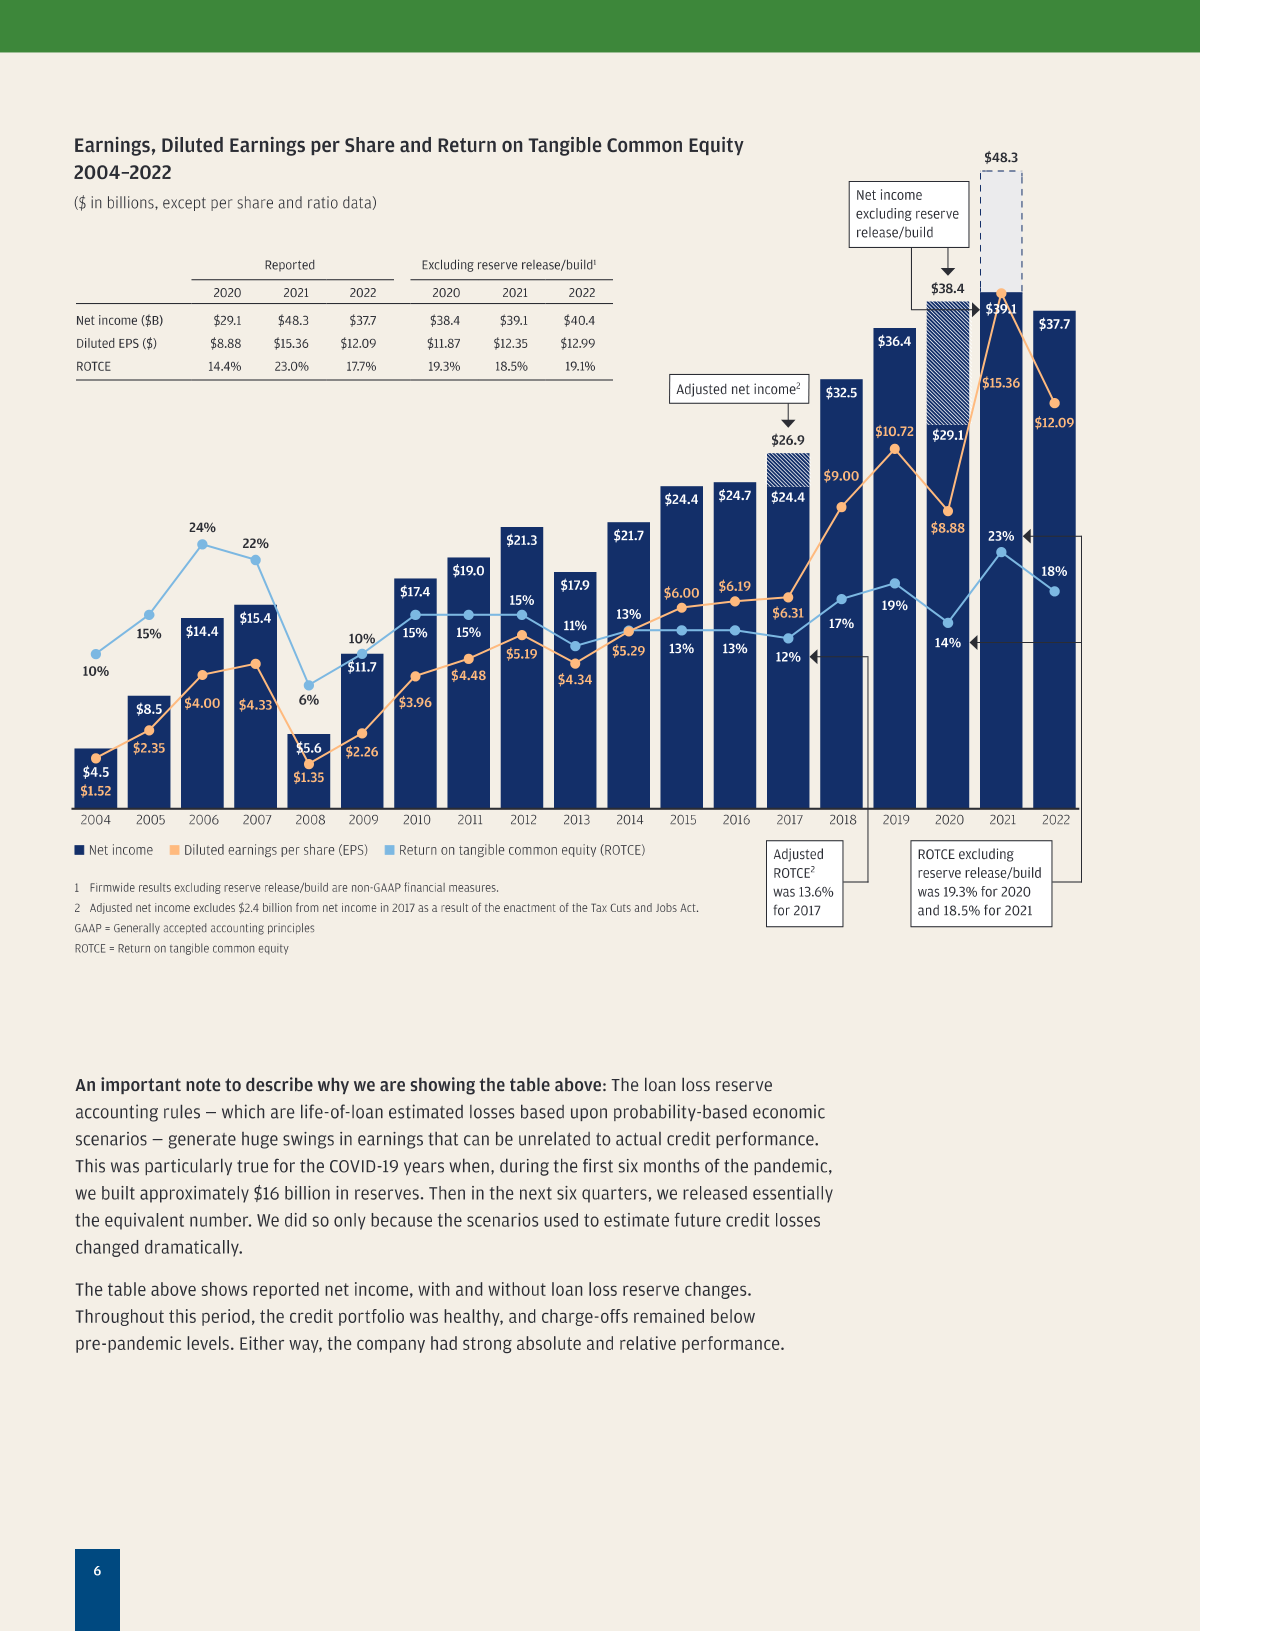

In [4]:
import fitz

# First we read the PDF file
# Then we convert the PDF to an image


pdf_path = "data/jpmc_annual_report_page_6.pdf"
doc = fitz.open(pdf_path)
img = convert_pdf_to_image(doc, page_number=0, dpi=150)
img

We will provide two prompts to the model:
- **Text Prompt**: Provide instructions for what data to extract from the image and the desired output format
- **Image Prompt**: Provide the image to the model as a base64 encoded string

In [9]:
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"

text_prompt = """
Extract the data contained in the chart and provide it in a json format.
The data should include the Net Income, Diluted EPS, and ROTCE from 
2004 to 2022 and should be structured as follows:
{"net_income":{"units:"$B", "data_points":{"2004": 4.5}}, "diluted_eps":{...}, "rotce":{...}}

"""
image_prompt = convert_pil_image_to_b64(img)

In [10]:
body = json.dumps(
    {
        "max_tokens": 1024,
        "messages": prompts_to_messages(
            [
                {
                    "role": "user",
                    "text_prompt": text_prompt,
                    "image_prompt": image_prompt,
                },
                {"role": "assistant", "text_prompt": "```json"}, # we start the generated response with a json code block to format the response
            ]
        ),
        "anthropic_version": "bedrock-2023-05-31",
    }
)

modelId = "anthropic.claude-3-sonnet-20240229-v1:0" 
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read().decode("utf8"))

rprint(Markdown(f'```json\n{response_body.get("content")[0]["text"]}'))

                                                                                                                   
                                                                                                                   
 {                                                                                                                 
   "net_income": {                                                                                                 
     "units": "$B",                                                                                                
     "data_points": {                                                                                              
       "2004": 4.5,                                                                                                
       "2005": 8.5,                                                                                                
       "2006": 14.4,                                                                                               
       "2007": 15.4,                                                                                               
       "2008": 5.6,                                                                                                
       "2009": 11.7,                                                                                               
       "2010": 17.4,                                                                                               
       "2011": 19.0,                                                                                               
       "2012": 21.3,                                                                                               
       "2013": 17.9,                                                                                               
       "2014": 21.8,                                                                                               
       "2015": 24.4,                                                                                               
       "2016": 24.7,                                                                                               
       "2017": 24.4,                                                                                               
       "2018": 32.5,                                                                                               
       "2019": 36.4,                                                                                               
       "2020": 29.1,                                                                                               
       "2021": 48.3,                                                                                               
       "2022": 37.7                                                                                                
     }                                                                                                             
   },                                                                                                              
   "diluted_eps": {                                                                                                
     "units": null,                                                                                                
     "data_points": {                                                                                              
       "2004": 3.32,                                                                                               
       "2005": 4.33,                                                                                               
       "2006": 6.0,                                                                                                
       "2007": 4.38,                                                                                               
       "2008": 0.59,                                    

Are the numbers above accurate? With such a simple prompt, likely not.

What can we do to make it better? 

See if you can adjust the prompt to get more accurate results.


## Conclusion

We are just getting warmed up, we explored basic prompting techiques with Claude model. Please proceed to the next Notebook.

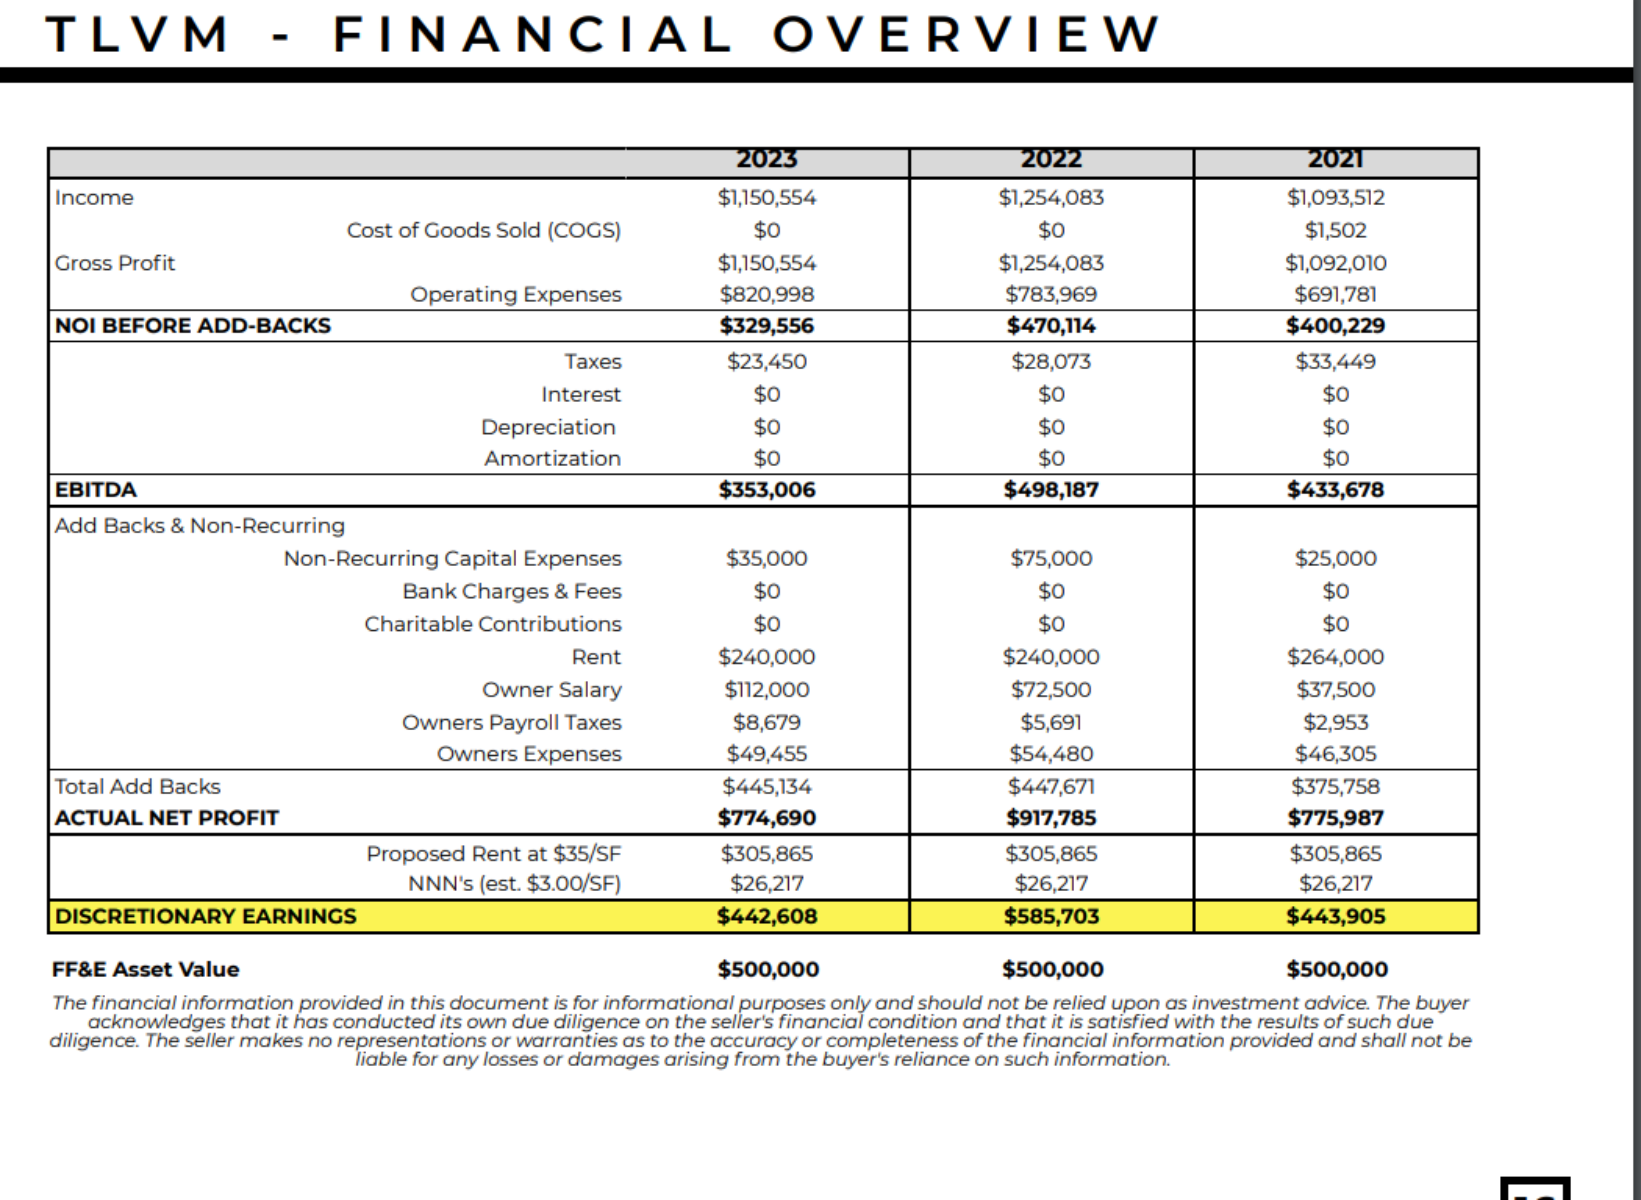

In [11]:
import fitz

# First we read the PDF file
# Then we convert the PDF to an image


pdf_path = "learninvillagefinantial.png"
doc = fitz.open(pdf_path)
img = convert_pdf_to_image(doc, page_number=0, dpi=150)
img

In [15]:
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"

text_prompt = """
based on your analyziz ' Analayzing the financial overview document, the "Discretionary Earnings" for this business in 2023 is projected to be $442,608. This figure represents the company\'s net profit after accounting for operating expenses, taxes, add-backs (like non-recurring capital expenses, rent, owner salary/expenses), and adjusting for proposed rent and a seller\'s discretionary earnings test of $300,551.\n\nThe key factors that contribute to this projected discretionary earnings figure of $442,608 in 2023 include:\n\n1) A high gross profit of $1,150,554 from total income with no cost of goods sold.\n2) Relatively stable operating expenses of $820,998.\n3) Inclusion of significant add-back expenses like $240,000 rent, $112,000 owner salary, and $35,000 non-recurring capital expenses.\n4) Adjustments for proposed rent and the seller\'s discretionary earnings test amount.\n\nBased on the detailed financial information provided, the business appears to be profitable with the discretionary earnings serving as an estimate of the funds potentially available to a new owner after accounting for operating costs and owner\'s compensation. However, a prospective buyer should perform their own due diligence to validate these projections.\n```'

how much I should offer to buy thjs business 
"""
image_prompt = convert_pil_image_to_b64(img)

In [16]:
body = json.dumps(
    {
        "max_tokens": 1024,
        "messages": prompts_to_messages(
            [
                {
                    "role": "user",
                    "text_prompt": text_prompt,
                    "image_prompt": image_prompt,
                },
                {"role": "assistant", "text_prompt": "```json"}, # we start the generated response with a json code block to format the response
            ]
        ),
        "anthropic_version": "bedrock-2023-05-31",
    }
)

modelId = "anthropic.claude-3-sonnet-20240229-v1:0" 
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read().decode("utf8"))

rprint(Markdown(f'```json\n{response_body.get("content")[0]["text"]}'))

                                                                                                                   
                                                                                                                   
 Based on the financial overview provided, the projected Discretionary Earnings for 2023 is $442,608. This figure  
 accounts for the actual net profit as well as addbacks like rent, owner's salary, and other adjustments.          
                                                                                                                   
 When valuing a business to acquire, a common approach is to use a multiple of the Discretionary Earnings as the   
 starting point for determining an offer price. Typical multiples can range from 2-4 times Discretionary Earnings  
 depending on factors like[38;2;248;248;242;48;2;39;4

In [17]:
response_body.get("content")[0]["text"]

"\nBased on the financial overview provided, the projected Discretionary Earnings for 2023 is $442,608. This figure accounts for the actual net profit as well as addbacks like rent, owner's salary, and other adjustments.\n\nWhen valuing a business to acquire, a common approach is to use a multiple of the Discretionary Earnings as the starting point for determining an offer price. Typical multiples can range from 2-4 times Discretionary Earnings depending on factors like growth potential, risk profile, market conditions, etc.\n\nSo if targeting a relatively conservative multiple around 3 times Discretionary Earnings, a reasonable initial offer range could be:\n\n3 x $442,608 Discretionary Earnings = $1,327,824\n\nHowever, I would recommend conducting thorough due diligence on the business' operations, competitive position, growth prospects, and verifying the financial projections before finalizing an offer price. It's also advisable to consult with professional advisors well-versed in b

In [18]:

modelId = "anthropic.claude-3-sonnet-20240229-v1:0"

text_prompt = """
based on your analyziz ' Analayzing the financial overview document, the "Discretionary Earnings" for this business in 2023 is projected to be $442,608. This figure represents the company\'s net profit after accounting for operating expenses, taxes, add-backs (like non-recurring capital expenses, rent, owner salary/expenses), and adjusting for proposed rent and a seller\'s discretionary earnings test of $300,551.\n\nThe key factors that contribute to this projected discretionary earnings figure of $442,608 in 2023 include:\n\n1) A high gross profit of $1,150,554 from total income with no cost of goods sold.\n2) Relatively stable operating expenses of $820,998.\n3) Inclusion of significant add-back expenses like $240,000 rent, $112,000 owner salary, and $35,000 non-recurring capital expenses.\n4) Adjustments for proposed rent and the seller\'s discretionary earnings test amount.\n\nBased on the detailed financial information provided, the business appears to be profitable with the discretionary earnings serving as an estimate of the funds potentially available to a new owner after accounting for operating costs and owner\'s compensation. However, a prospective buyer should perform their own due diligence to validate these projections.\n```'

how the employees salary has been calculated 
"""
image_prompt = convert_pil_image_to_b64(img)

body = json.dumps(
    {
        "max_tokens": 1024,
        "messages": prompts_to_messages(
            [
                {
                    "role": "user",
                    "text_prompt": text_prompt,
                },
                {"role": "assistant", "text_prompt": "```json"}, # we start the generated response with a json code block to format the response
            ]
        ),
        "anthropic_version": "bedrock-2023-05-31",
    }
)

modelId = "anthropic.claude-3-sonnet-20240229-v1:0" 
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read().decode("utf8"))

rprint(Markdown(f'```json\n{response_body.get("content")[0]["text"]}'))

                                                                                                                   
                                                                                                                   
                                                                                                                   
 based on analysis review of your financial overview, there is no specific line item or details provided regarding 
 how employee salaries were calculated. The document only mentions an add-back of $112,000 for "owner salary", but 
 does not break down salaries for other employees.                                                                 
                                                                                                                   
 Typically, employee salaries would be categorized under operating expenses as either:                             
                                                                                                                   
 1) Salary/Wage Expense - This would cover base salaries/wages for all non-owner employees.[48;2;39;40;

In [19]:
response_body.get("content")[0]["text"]

'\n\nbased on analysis review of your financial overview, there is no specific line item or details provided regarding how employee salaries were calculated. The document only mentions an add-back of $112,000 for "owner salary", but does not break down salaries for other employees.\n\nTypically, employee salaries would be categorized under operating expenses as either:\n\n1) Salary/Wage Expense - This would cover base salaries/wages for all non-owner employees.\n\n2) Payroll Taxes and Benefits - This covers the employer\'s portion of payroll taxes, health insurance, retirement contributions etc.\n\nHowever, the financial overview does not provide that level of granular detail on the operating expense line items. The operating expenses of $820,998 are presented as one consolidated figure.\n\nTo understand how employee salaries were calculated, you would need additional supporting documentation like:\n\n- A payroll register listing out each employee, their salary/wage rates, hours worked